<a href="https://colab.research.google.com/github/dimarsoft/ml_mnist/blob/main/PyTorch_mnist_for_Kate_24_11_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в нейронные сети
## Задание 1

### Импортируем все необходимые библиотеки

In [6]:
# библиотеки torchinfo нет в Colab, но можно установить: !pip3 install torchinfo
!pip3 install torchinfo


In [14]:
"""
Разпознование цифр Mnist с помощью PyTorch.

Смотрел примеры:

https://github.com/pytorch/examples/tree/main/mnist_hogwild

https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc

https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/

https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch/notebook

"""

from typing import Tuple, Any, List

import numpy as np
from matplotlib import pyplot as plt

import torch

from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as torch_func

# библиотеки для вывода информации о модели
from torchsummary import summary as summary_1

from torchinfo import summary as summary_2

from prettytable import PrettyTable

# позволит график обновлять
from IPython import display
import random

### Скачиваем датасет mnist

In [9]:

def one_hot_transform(target):
    return torch_func.one_hot(torch.tensor(target), num_classes=10).to(dtype=torch.float)

def get_train_and_test_data(batch_size=10, batch_size_test=4):
    # x (входы) трансформируем в тензоры
    transform = transforms.ToTensor()
    """
    так же можно применять несколько трасформаторов и данные нормализовать и/или конвертировать в диапазон [0, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ])
    """

    # y (ответы) кодируем в one_hot, т.к категории

    target_transform = one_hot_transform

    print(f"mnist start load ...")

    mnist_train = datasets.MNIST(root='mnist', download=True, train=True, transform=transform,
                                 target_transform=target_transform)
    mnist_test = datasets.MNIST(root='mnist', download=True, train=False, transform=transform,
                                target_transform=target_transform)

    train_loader = DataLoader(mnist_train, batch_size=batch_size)
    test_loader = DataLoader(mnist_test, batch_size=batch_size_test)

    print(f"mnist loaded ...")

    return train_loader, test_loader

**Создаём модель 1**

In [10]:
def create_model(norm=False, dropout=False, batch_norm=False):
    """
    Создание модели
    :param batch_norm:
    Добавить слой BatchNorm
    :param dropout:
    Добавить слой Dropout
    :param norm:
    Добавить слой для нормализации данных
    :return: Модель
    """
    model = nn.Sequential()
    model.append(nn.Flatten())

    if norm:
        model.append(nn.LayerNorm(784))

    model.append(nn.Linear(in_features=784, out_features=128))
    model.append(nn.ReLU())

    if batch_norm:
        model.append(nn.BatchNorm1d(num_features=128))

    if dropout:
        model.append(nn.Dropout(0.5))

    model.append(nn.Linear(in_features=128, out_features=64))
    model.append(nn.ReLU())

    if dropout:
        model.append(nn.Dropout(0.5))

    model.append(nn.Linear(in_features=64, out_features=10))

    if dropout:
        model.append(nn.Dropout(0.25))

    model.append(nn.Sigmoid())

    return model

**Создаём модель 2**

In [11]:
def create_model_conv2d():
    """
    Создание более сложной/тяжелой модели
    :return:
    """
    model = new_model = nn.Sequential()

    model.append(nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=0))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=0))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2, 2)))
    model.append(nn.Dropout(0.25))

    model.append(nn.Flatten())
    model.append(nn.Linear(32 * 12 * 12, 128))
    model.append(nn.ReLU())
    model.append(nn.Dropout(0.5))
    model.append(nn.Linear(in_features=128, out_features=10))
    model.append(nn.Softmax(dim=1))

    return new_model

**Фукции для обучение модели**

In [12]:
def train(model, train_loader, loss_function, optimizer, device, epoch, log_interval=-1) -> Tuple[float, float]:
    """
    Обучение модели и сбор метрик: loss и accuracy
    :param model:
    :param train_loader:
    :param loss_function:
    :param optimizer:
    :param device:
    :param epoch:
    :param log_interval:
    :return:
    """
    # return 0, 0
    # return random.random(), random.random()
    model.train()

    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)

        prediction = output.argmax(axis=1, keepdims=True)
        y_n = target.argmax(axis=1, keepdims=True)
        correct += prediction.eq(y_n.view_as(prediction)).sum().item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if log_interval > 0 & (batch_idx % log_interval == 0):
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    total_items = len(train_loader.dataset)

    total_loss /= total_items
    correct /= total_items

    return total_loss, correct


def eval_model(model, train_loader, loss_function, device, epoch, log_interval=-1) -> Tuple[float, float]:
    """
    Проверка модели на тестовой выборке и сбор метрик: loss и accuracy
    :param model:
    :param train_loader:
    :param loss_function:
    :param device:
    :param epoch:
    :param log_interval:
    :return:
    """

    # return random.random(), random.random()
    model.eval()

    total_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_function(output, target)

        prediction = output.argmax(axis=1, keepdims=True)
        y_n = target.argmax(axis=1, keepdims=True)

        correct += prediction.eq(y_n.view_as(prediction)).sum().item()

        loss.backward()

        total_loss += loss.item()

        if log_interval > 0 & (batch_idx % log_interval == 0):
            print(f'Eval Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    total_items = len(train_loader.dataset)

    total_loss /= total_items
    correct /= total_items

    return total_loss, correct

In [13]:

def show_graphs(train_loss_hist, test_loss_hist, train_accuracy_hist, test_accuracy_hist):
    """
    Отбражение графиков loss и accuracy
    :param train_loss_hist:
    :param test_loss_hist:
    :param train_accuracy_hist:
    :param test_accuracy_hist:
    :return:
    """

    fig = plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.title('Train Accuracy')
    plt.plot(np.arange(len(train_accuracy_hist)), train_accuracy_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.title('Test Accuracy')
    plt.plot(np.arange(len(test_accuracy_hist)), test_accuracy_hist)
    plt.yscale('log')
    plt.grid()

    # plt.show()
    # matplotlib.pyplot.tight_layout
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
    plt.tight_layout()
    display.display(fig)
    display.clear_output(wait=True)


In [15]:
def show_graphs_on_axis(ax: List, y: List[List], captions: List[str], clear=True) -> None:
    """
    Построение графиков
    :param ax: Массив осей
    :param y: Массив с данными для каждой оси
    :param captions: Массив заголовков для осей
    :param clear: Очистка предыдущего графика
    :return:
    """
    for i in range(len(ax)):
        if clear:
            ax[i].clear()
        ax[i].plot(np.arange(len(y[i])), y[i])
        ax[i].set_title(captions[i])
        ax[i].grid(True)

**Обучение модели**


In [21]:
def train_model(model_to_train, train_loader, test_loader, device, epochs=10, log_interval=-1, show_graph=True) -> None:
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_to_train.parameters(), lr=1e-1)

    train_loss_hist = []
    test_loss_hist = []

    train_accuracy_hist = []
    test_accuracy_hist = []

    print(f"start train: epochs = {epochs}, device = {device}")

    # Создаем на чем рисовать графики: 2x2
    fig, axis = plt.subplots(2, 2, figsize=(12, 8))

    # заголовок окна
    # plt.get_current_fig_manager().set_window_title('Обучение модели')

    # 2x2 в массив из 4 элементов
    axis = axis.flatten()

    # данные для графиков
    y = [train_loss_hist, test_loss_hist, train_accuracy_hist, test_accuracy_hist]

    # подписи для графиков
    captions = ["train_loss", "test_loss", "train_accuracy", "test_accuracy"]

    # создаем сначала пустой график

    show_graphs_on_axis(axis, y, captions, clear=False)

    for i in range(epochs):

        train_loss, train_accuracy = train(model_to_train, train_loader, loss_function, optimizer, device, i,
                                           log_interval=log_interval)
        test_loss, test_accuracy = eval_model(model_to_train, test_loader, loss_function, device, i,
                                              log_interval=log_interval)

        if show_graph:
            train_loss_hist.append(train_loss)
            train_accuracy_hist.append(train_accuracy)
            test_loss_hist.append(test_loss)
            test_accuracy_hist.append(train_accuracy)


            fig.suptitle(f'Epoch {i+1}/{epochs}')
            show_graphs_on_axis(axis, y, captions)
            # show_graphs(train_loss_hist, test_loss_hist, train_accuracy_hist, test_accuracy_hist)

            # обновляем и оставляем только одну фигуру

            plt.tight_layout()
            display.display(fig)
            display.clear_output(wait=True)
        else:
            print(f"epoch: {i + 1}/{epochs}, "
                  f"train_loss = {train_loss:.6f}, train_accuracy = {train_accuracy:.6f}, "
                  f"test_loss = {test_loss:.6f}, test_accuracy = {test_accuracy:.6f}")



    # завершаем
    plt.close()
    #plt.show()


In [17]:
def get_device():
    use_cuda = torch.cuda.is_available()

    print(f"use_cuda = {use_cuda}")

    if use_cuda:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [18]:

def print_count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


**Модель №1**

In [19]:
def model_1(epochs=10):
    print("Test simple model")

    # устройство на котором обучаем, CPU/GPU
    my_device = get_device()

    # создаем модель и переносим на устройство
    model = create_model().to(my_device)

    print("1. summary from torchsummary")
    summary_1(model, (28, 28, 1))

    print("2. summary from torchinfo")
    summary_2(model, depth=4, verbose=1)

    print_count_parameters(model)

    # загрузка и подготовка датасета
    train_loader, test_loader = get_train_and_test_data()

    # запуск обучения

    train_model(model, train_loader, test_loader, device=my_device, epochs=epochs)

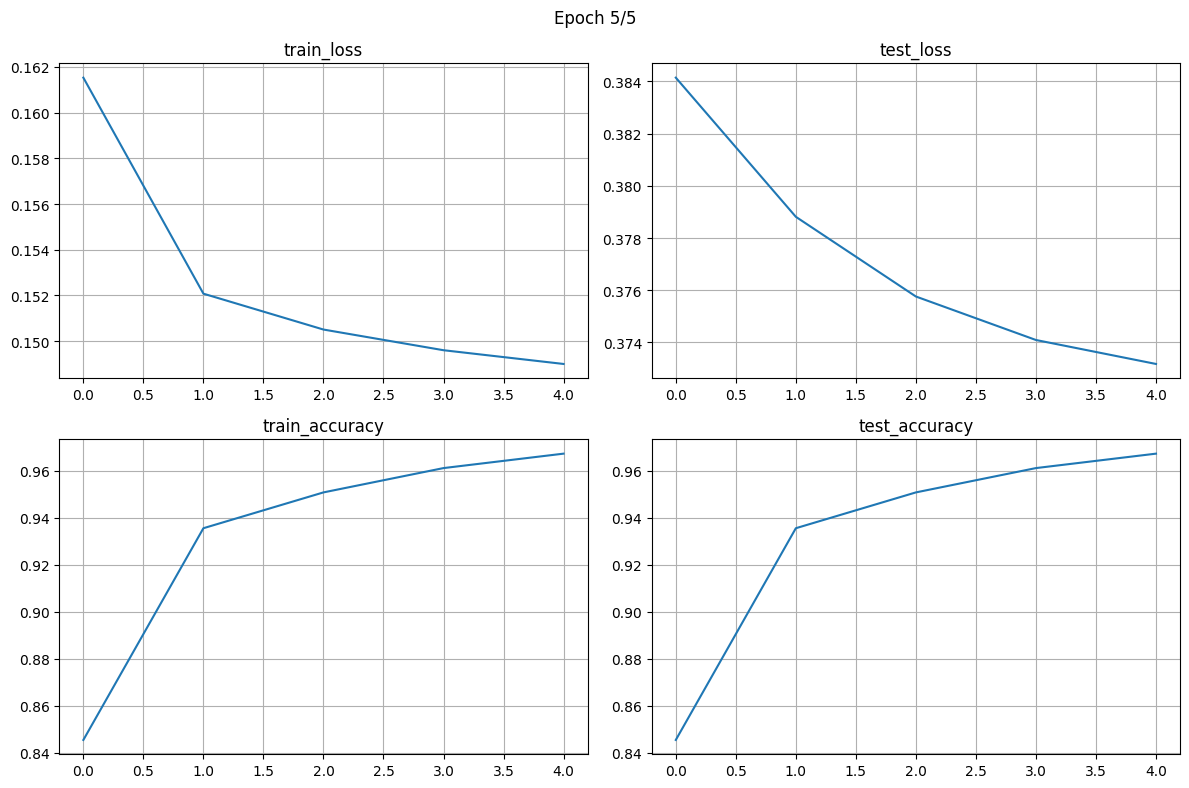

In [22]:
model_1(5)

**Модель №2**

In [ ]:
def model_2(epochs=10):
    print("Test hard model")

    # устройство на котором обучаем, CPU/GPU
    my_device = get_device()

    # создаем модель и переносим на устройство
    model = create_model_conv2d().to(my_device)

    print_count_parameters(model)

    # загрузка и подготовка датасета
    train_loader, test_loader = get_train_and_test_data()

    # запуск обучения

    train_model(model, train_loader, test_loader, device=my_device, epochs=epochs)

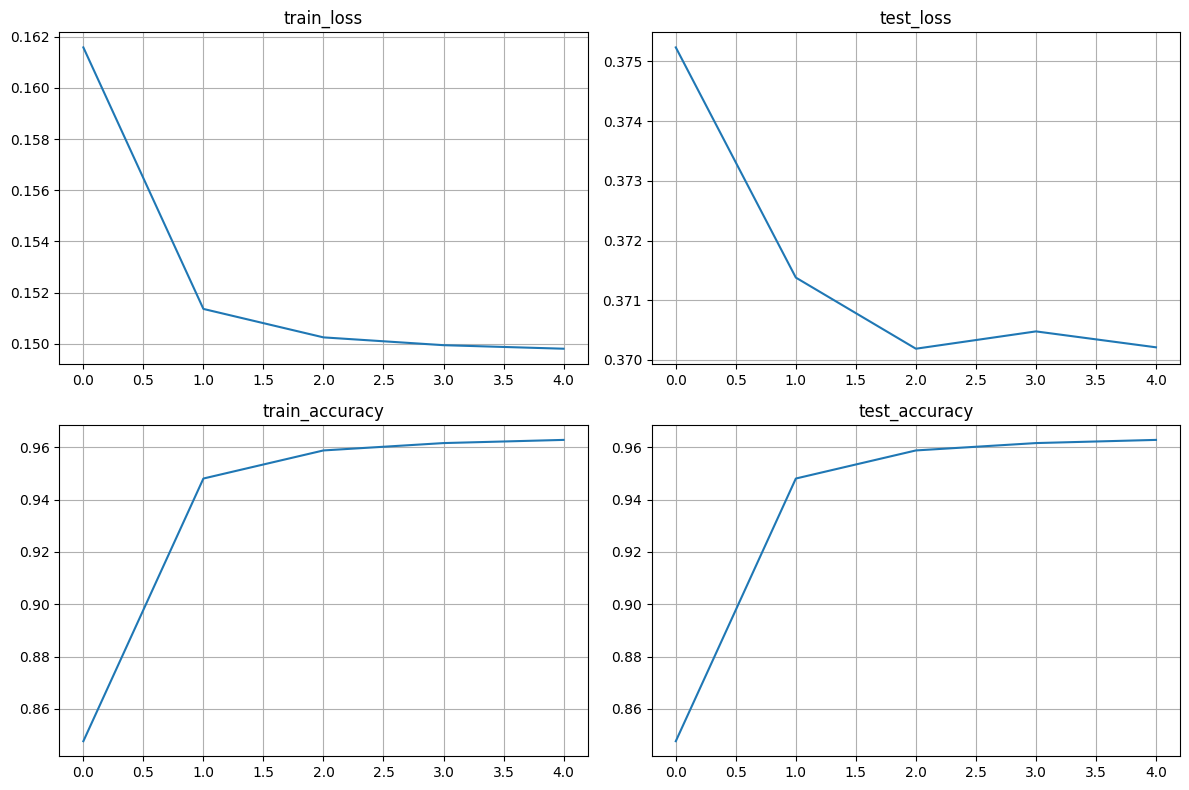

In [ ]:
model_2(5)

### Сравниваем несколько архитектур:

1)

2)

3)

## Выводы:

т